# **FLO Customer Segmentation with RFM Analysis**

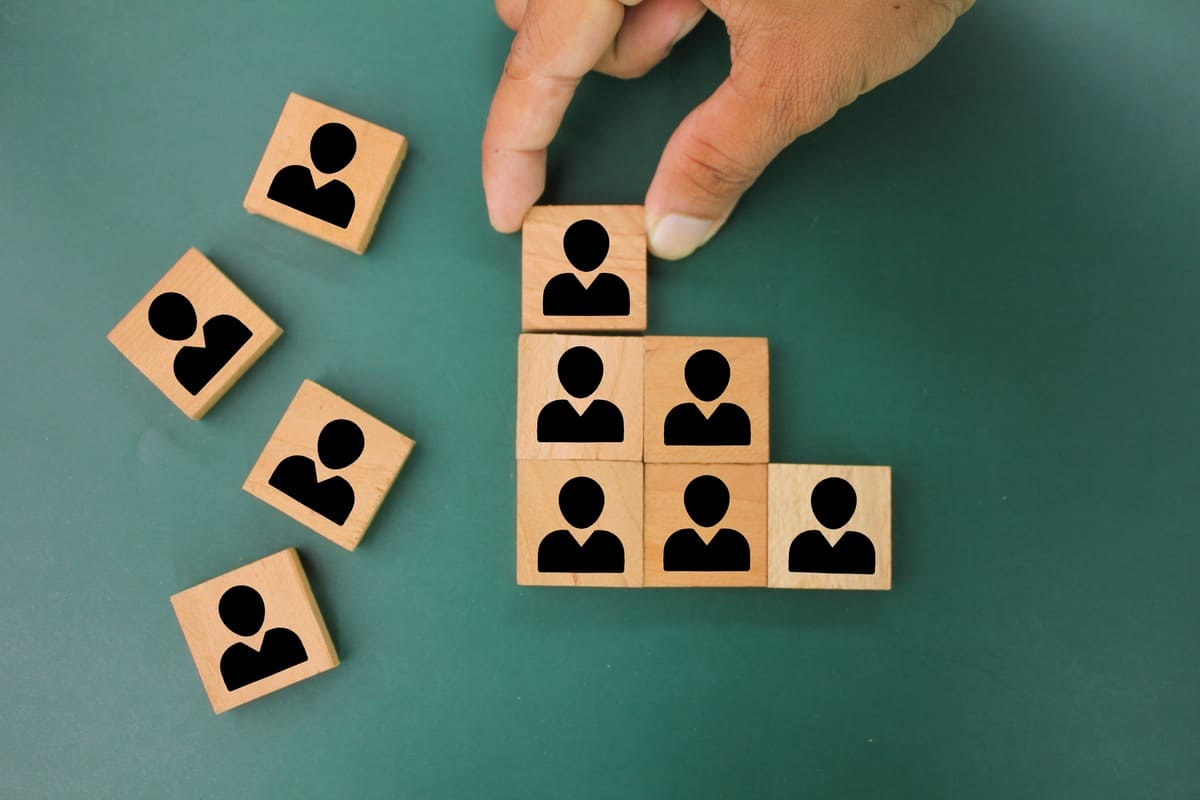

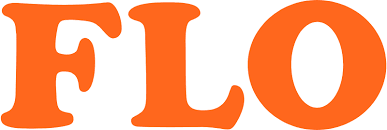

##  **Business Problem**

FLO (Footwear Sales Store) wants to divide its customers into segments and determine marketing strategies according to these segments. To this end, customer behaviors will be defined and groups will be created according to these behavior clusters.

## **The Data Set Story**

The dataset consists of information obtained from the past shopping behavior of customers who made their last purchases as OmniChannel (both online and offline shopping) in 2020 - 2021.

**Features in the Dataset:**

* **master_id:** Unique customer number
* **order_channel:** Which channel is used for the shopping platform (Android, ios, Desktop, Mobile, Offline)
* **last_order_channel:** The channel where the last shopping was done
* **first_order_date:** The customer's first shopping date
* **last_order_date:** The customer's last shopping date
* **last_order_date_online:** The customer's last shopping date on the online platform
* **last_order_date_offline:** The customer's last shopping date on the offline platform
* **order_num_total_ever_online:** The total number of online shoppings made by the customer
* **order_num_total_ever_offline:** The total number of offline shoppings made by the customer
* **customer_value_total_ever_offline:** The total amount of money paid by the customer for offline shopping
* **customer_value_total_ever_online:** The total amount of money paid by the customer for online shopping
* **interested_in_categories_12:** List of categories the customer has shopped in the last 12 months

In [1]:
# Import Libraries
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# Load Data (Kaggle Path)
df = pd.read_csv("/kaggle/input/flo-data/flo_data_20k.csv")

In [3]:
# writing a function to look at the overall picture
def check_df(dataframe, head=10):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Columns #####################")
    print(dataframe.columns)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [4]:
check_df(df)

##################### Shape #####################
(19945, 12)
##################### Columns #####################
Index(['master_id', 'order_channel', 'last_order_channel', 'first_order_date',
       'last_order_date', 'last_order_date_online', 'last_order_date_offline',
       'order_num_total_ever_online', 'order_num_total_ever_offline',
       'customer_value_total_ever_offline', 'customer_value_total_ever_online',
       'interested_in_categories_12'],
      dtype='object')
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_to

## **Data Preparation & Feature Engineering**

In [5]:
# 1. Create Total Spending and Order Count Features
df["Total_Value"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]
df["Total_Order"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]

In [6]:
# 2. Convert Date Columns to DateTime
date_columns = [col for col in df.columns if 'date' in col.lower()]
for col in date_columns:
    df[col] = pd.to_datetime(df[col])

## **Exploratory Data Visualizations**

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


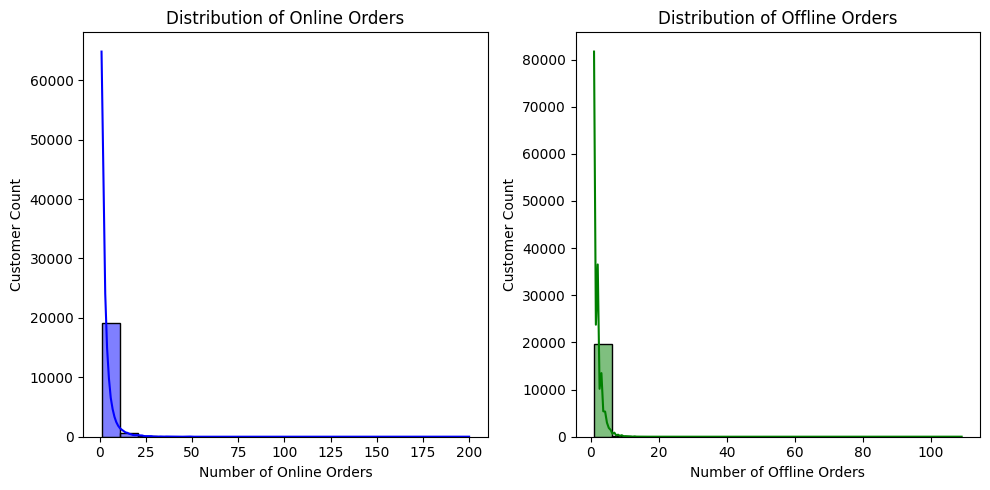

In [7]:
# 1. Online vs. Offline Order Distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['order_num_total_ever_online'], bins=20, color='blue', kde=True)
plt.title('Distribution of Online Orders')
plt.xlabel('Number of Online Orders')
plt.ylabel('Customer Count')

plt.subplot(1, 2, 2)
sns.histplot(df['order_num_total_ever_offline'], bins=20, color='green', kde=True)
plt.title('Distribution of Offline Orders')
plt.xlabel('Number of Offline Orders')
plt.ylabel('Customer Count')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


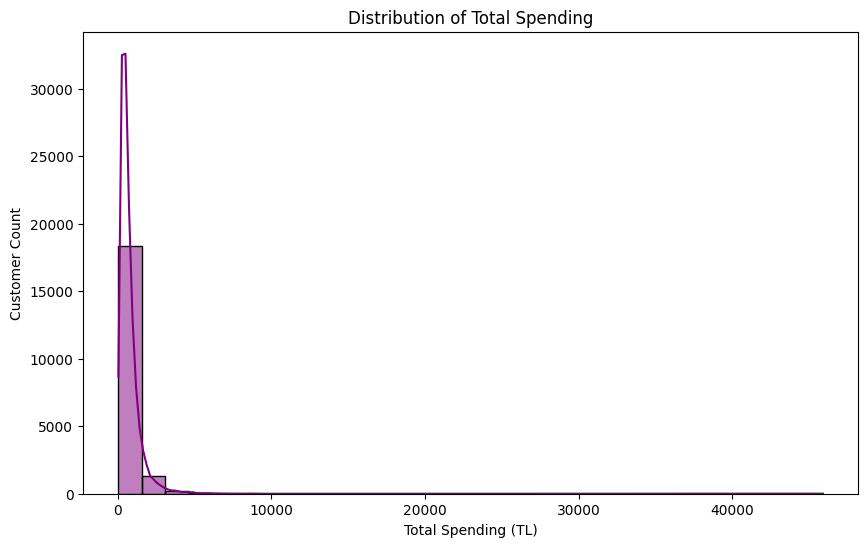

In [8]:
# 2. Total Spending Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Total_Value'], bins=30, color='purple', kde=True)
plt.title('Distribution of Total Spending')
plt.xlabel('Total Spending (TL)')
plt.ylabel('Customer Count')
plt.show()

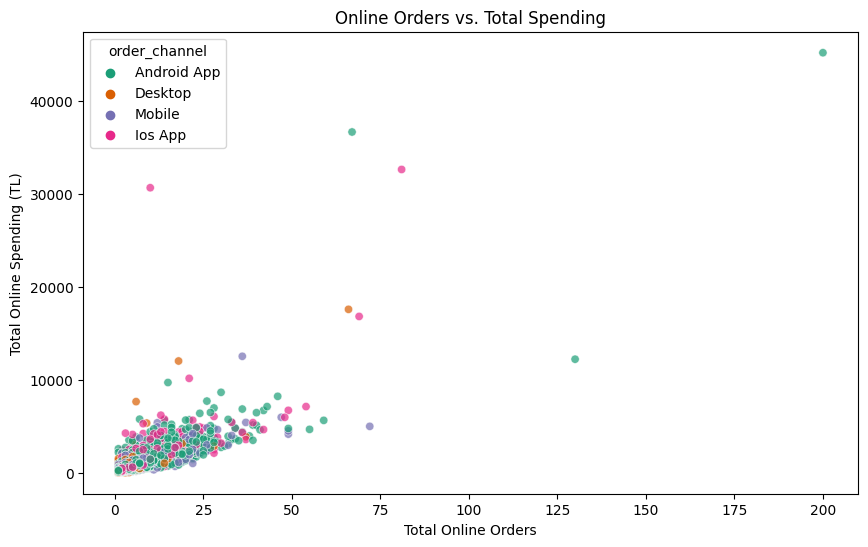

In [9]:
# 3. Relationship Between Total Orders and Spending
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, 
                x='order_num_total_ever_online', 
                y='customer_value_total_ever_online',
                hue=df['order_channel'],
                palette="Dark2",
                alpha=0.7)
plt.title('Online Orders vs. Total Spending')
plt.xlabel('Total Online Orders')
plt.ylabel('Total Online Spending (TL)')
plt.show()

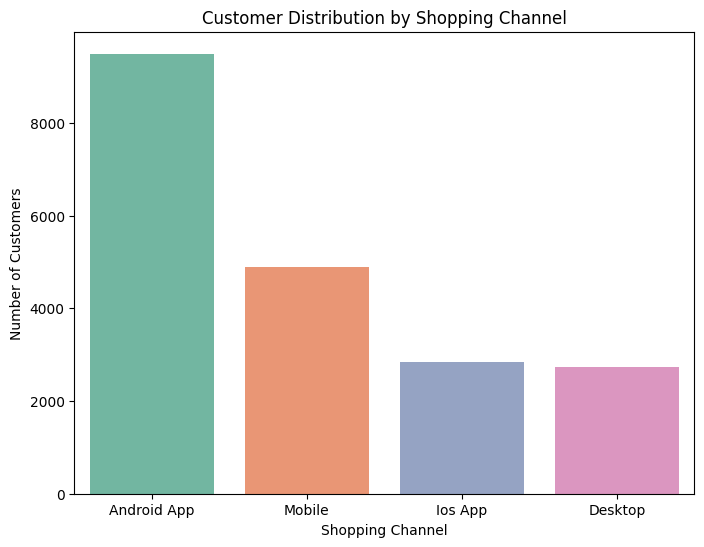

In [10]:
# 4. Distribution of Customers by Shopping Channel
plt.figure(figsize=(8, 6))
channel_dist = df['order_channel'].value_counts()
sns.barplot(x=channel_dist.index, y=channel_dist.values, palette="Set2")
plt.title('Customer Distribution by Shopping Channel')
plt.xlabel('Shopping Channel')
plt.ylabel('Number of Customers')
plt.show()

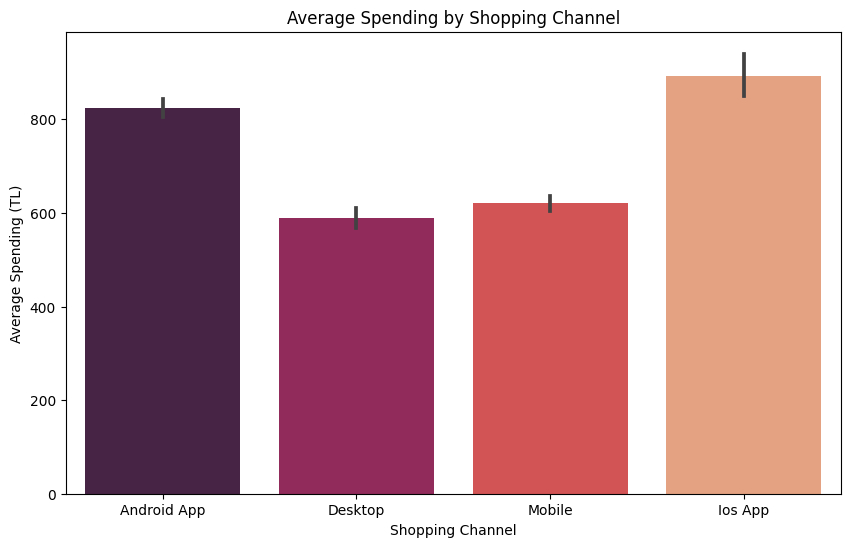

In [11]:
# 5. Order Channel vs. Average Spending
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='order_channel', y='Total_Value', palette="rocket", estimator='mean')
plt.title('Average Spending by Shopping Channel')
plt.xlabel('Shopping Channel')
plt.ylabel('Average Spending (TL)')
plt.show()

## **RFM Metric Calculation**

In [12]:
# Set Analysis Date (2 days after last purchase)
analysis_date = df["last_order_date"].max() + dt.timedelta(days=2)

In [13]:
# Calculate RFM Metrics
rfm = df.groupby('master_id').agg({
    'last_order_date': lambda x: (analysis_date - x.max()).days,  # Recency
    'Total_Order': 'sum',                                          # Frequency
    'Total_Value': 'sum'                                           # Monetary
}).reset_index()

rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']

## **RFM Scoring & Segmentation**

In [14]:
# Calculate RFM Scores
rfm['recency_score'] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1])
rfm['frequency_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['monetary_score'] = pd.qcut(rfm['monetary'], 5, labels=[1,2,3,4,5])

In [15]:
# Create RFM Composite Score
rfm['RFM_Score'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str)

In [16]:
# Define Segments
segmentation_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_risk',
    r'[1-2]5': 'critical',
    r'3[1-2]': 'dormant',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal',
    r'41': 'promising',
    r'51': 'new',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

rfm['segment'] = rfm['RFM_Score'].replace(segmentation_map, regex=True)

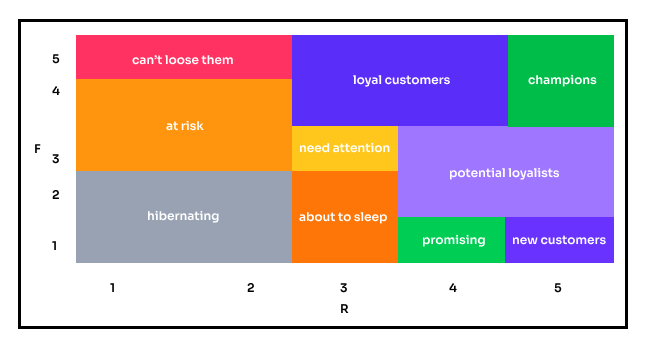

## **Key Analysis Outputs**

In [17]:
# 1. Segment Statistics
segment_stats = rfm.groupby('segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).reset_index()

print("Segment Statistics:")
print(segment_stats)

Segment Statistics:
               segment recency frequency monetary      
                          mean      mean     mean count
0              at_risk 242.329     4.470  648.325  3152
1            champions  17.142     8.965 1410.709  1920
2             critical 235.159    10.717 1481.652  1194
3              dormant 114.032     2.407  361.649  1643
4          hibernating 247.426     2.391  362.583  3589
5                loyal  82.558     8.356 1216.257  3375
6       need_attention 113.037     3.739  553.437   806
7                  new  17.976     2.000  344.049   673
8  potential_loyalists  36.870     3.311  533.741  2925
9            promising  58.695     2.000  334.153   668


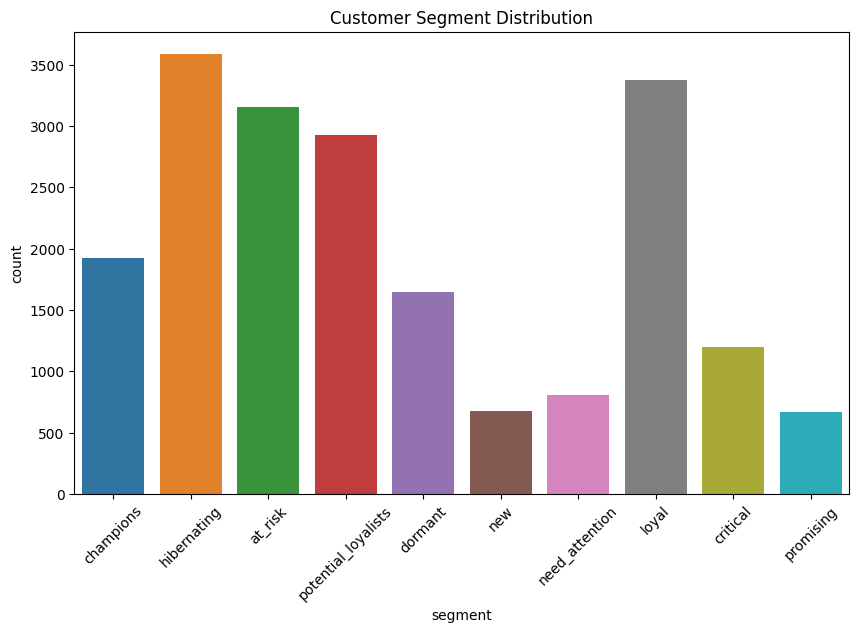

In [18]:
# Customer Segment Distribution
plt.figure(figsize=(10,6))
sns.countplot(data=rfm, x='segment')
plt.title('Customer Segment Distribution')
plt.xticks(rotation=45)
plt.show()

## **Finding customers with the relevant profile with the help of RFM analysis**

FLO is adding a new women's shoe brand to its portfolio. The product prices of the brand it is adding are above general customer preferences. For this reason, it is desired to contact customers with a profile that will be interested in the brand's promotion and product sales. It is planned that these customers will be loyal and shop from the women's category. Save the customer ID numbers to the csv file.

In [19]:
# Case 1: High-Value Women's Shoe Campaign
women_target = df.loc[
    (df['interested_in_categories_12'].str.contains('KADIN', na=False)) &
    (rfm['segment'].isin(['champions', 'loyal'])),
    'master_id'
]
women_target.to_csv('/kaggle/working/premium_womenshoe_target.csv', index=False)

A discount of nearly 40% is planned for Men's and Children's products. This discount is intended to specifically target customers who are good customers in the past but have not shopped for a long time and new customers who are interested in the relevant categories. Save the IDs of customers with the appropriate profile to the csv file.

In [20]:
# Case 2: Discount Campaign for Men/Children Products
discount_target = df.loc[
    (df['interested_in_categories_12'].str.contains('ERKEK|COCUK', na=False)) &
    (rfm['segment'].isin(['critical', 'at_risk', 'new'])),
    'master_id'
]
discount_target.to_csv('/kaggle/working/men_child_discount_target.csv', index=False)